In [1]:
import pandas as pd, numpy as np, os
import matplotlib.pyplot as plt, gc

train = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/train.csv')
print('Train shape', train.shape )

Train shape (106800, 15)


In [2]:
display(train.head())

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


In [8]:
NAMES = ['LL','LP','RP','RR']

FEATS = [['Fp1','F7','T3','T5','O1'],
         ['Fp1','F3','C3','P3','O1'],
         ['Fp2','F8','T4','T6','O2'],
         ['Fp2','F4','C4','P4','O2']]

directory_path = 'EEG_Spectrograms/'
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

In [9]:
import pywt
print("The wavelet functions we can use:")
print(pywt.wavelist())

USE_WAVELET = None #or "db8" or anything below

The wavelet functions we can use:
['bior1.1', 'bior1.3', 'bior1.5', 'bior2.2', 'bior2.4', 'bior2.6', 'bior2.8', 'bior3.1', 'bior3.3', 'bior3.5', 'bior3.7', 'bior3.9', 'bior4.4', 'bior5.5', 'bior6.8', 'cgau1', 'cgau2', 'cgau3', 'cgau4', 'cgau5', 'cgau6', 'cgau7', 'cgau8', 'cmor', 'coif1', 'coif2', 'coif3', 'coif4', 'coif5', 'coif6', 'coif7', 'coif8', 'coif9', 'coif10', 'coif11', 'coif12', 'coif13', 'coif14', 'coif15', 'coif16', 'coif17', 'db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9', 'db10', 'db11', 'db12', 'db13', 'db14', 'db15', 'db16', 'db17', 'db18', 'db19', 'db20', 'db21', 'db22', 'db23', 'db24', 'db25', 'db26', 'db27', 'db28', 'db29', 'db30', 'db31', 'db32', 'db33', 'db34', 'db35', 'db36', 'db37', 'db38', 'dmey', 'fbsp', 'gaus1', 'gaus2', 'gaus3', 'gaus4', 'gaus5', 'gaus6', 'gaus7', 'gaus8', 'haar', 'mexh', 'morl', 'rbio1.1', 'rbio1.3', 'rbio1.5', 'rbio2.2', 'rbio2.4', 'rbio2.6', 'rbio2.8', 'rbio3.1', 'rbio3.3', 'rbio3.5', 'rbio3.7', 'rbio3.9', 'rbio4.4', 'rbio5.5'

In [11]:
def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def denoise(x, wavelet='haar', level=1):    
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * maddest(coeff[-level])

    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

    ret=pywt.waverec(coeff, wavelet, mode='per')
    
    return ret


In [12]:
mel_spec = librosa.feature.melspectrogram(y=x, sr=200, hop_length=len(x)//256, 
          n_fft=1024, n_mels=128, fmin=0, fmax=20, win_length=128)


NameError: name 'x' is not defined

In [13]:
import librosa

def spectrogram_from_eeg(parquet_path, display=False):
    
    # LOAD MIDDLE 50 SECONDS OF EEG SERIES
    eeg = pd.read_parquet(parquet_path)
    middle = (len(eeg)-10_000)//2
    eeg = eeg.iloc[middle:middle+10_000]
    
    # VARIABLE TO HOLD SPECTROGRAM
    img = np.zeros((128,256,4),dtype='float32')
    
    if display: plt.figure(figsize=(10,7))
    signals = []
    for k in range(4):
        COLS = FEATS[k]
        
        for kk in range(4):
        
            # COMPUTE PAIR DIFFERENCES
            x = eeg[COLS[kk]].values - eeg[COLS[kk+1]].values

            # FILL NANS
            m = np.nanmean(x)
            if np.isnan(x).mean()<1: x = np.nan_to_num(x,nan=m)
            else: x[:] = 0

            # DENOISE
            if USE_WAVELET:
                x = denoise(x, wavelet=USE_WAVELET)
            signals.append(x)

            # RAW SPECTROGRAM
            mel_spec = librosa.feature.melspectrogram(y=x, sr=200, hop_length=len(x)//256, 
                  n_fft=1024, n_mels=128, fmin=0, fmax=20, win_length=128)

            # LOG TRANSFORM
            width = (mel_spec.shape[1]//32)*32
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).astype(np.float32)[:,:width]

            # STANDARDIZE TO -1 TO 1
            mel_spec_db = (mel_spec_db+40)/40 
            img[:,:,k] += mel_spec_db
                
        # AVERAGE THE 4 MONTAGE DIFFERENCES
        img[:,:,k] /= 4.0
        
        if display:
            plt.subplot(2,2,k+1)
            plt.imshow(img[:,:,k],aspect='auto',origin='lower')
            plt.title(f'EEG {eeg_id} - Spectrogram {NAMES[k]}')
            
    if display: 
        plt.show()
        plt.figure(figsize=(10,5))
        offset = 0
        for k in range(4):
            if k>0: offset -= signals[3-k].min()
            plt.plot(range(10_000),signals[k]+offset,label=NAMES[3-k])
            offset += signals[3-k].max()
        plt.legend()
        plt.title(f'EEG {eeg_id} Signals')
        plt.show()
        print(); print('#'*25); print()
        
    return img

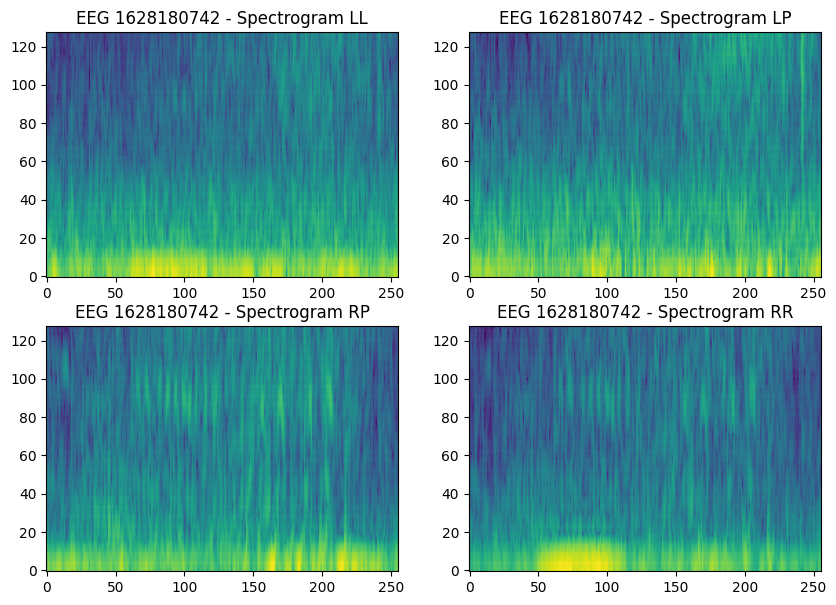

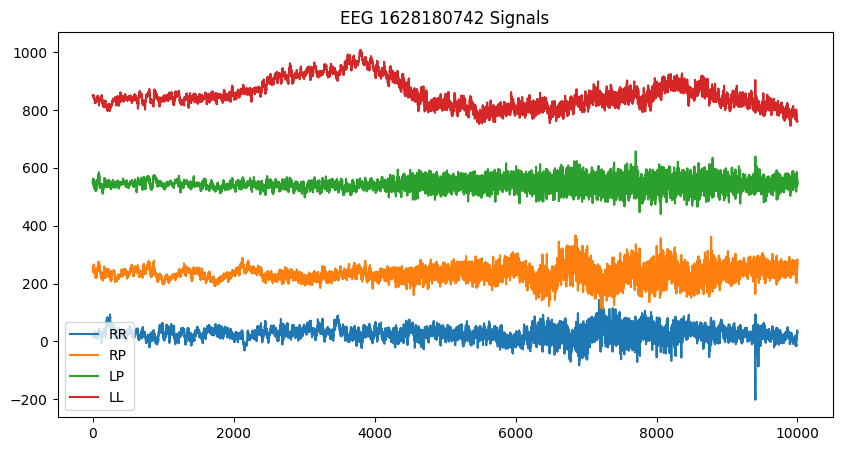


#########################



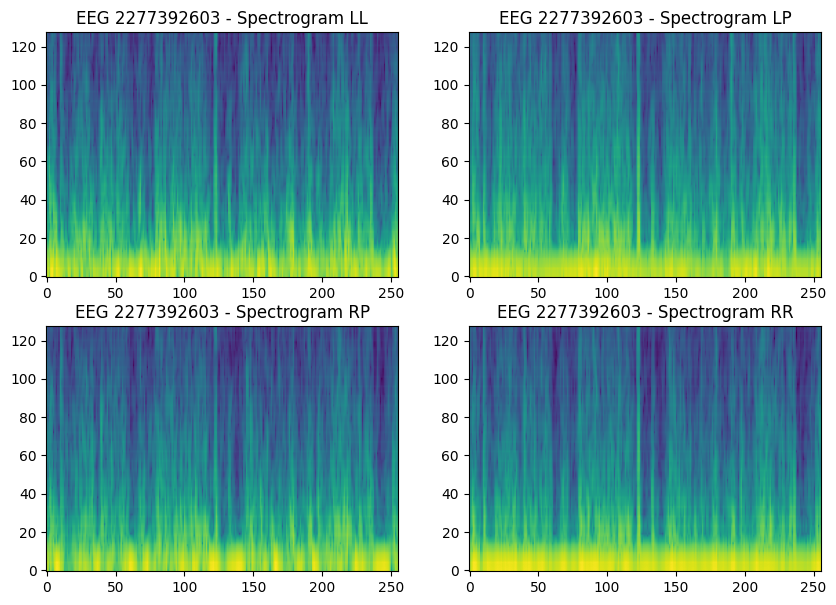

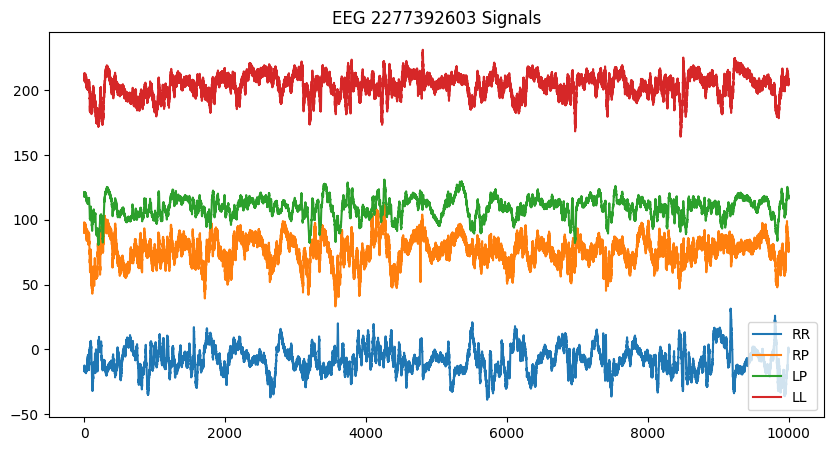


#########################



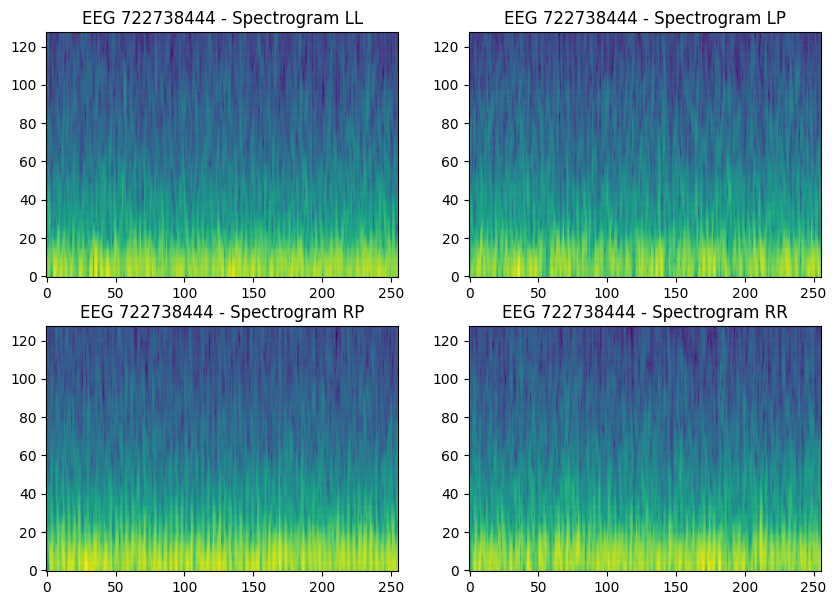

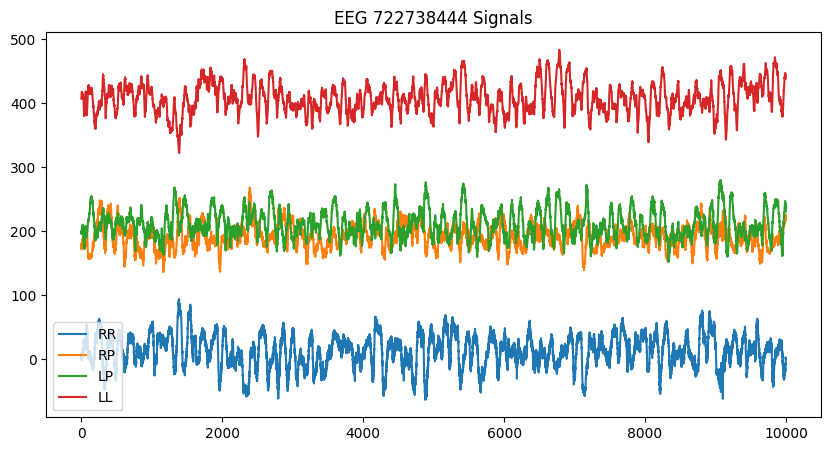


#########################



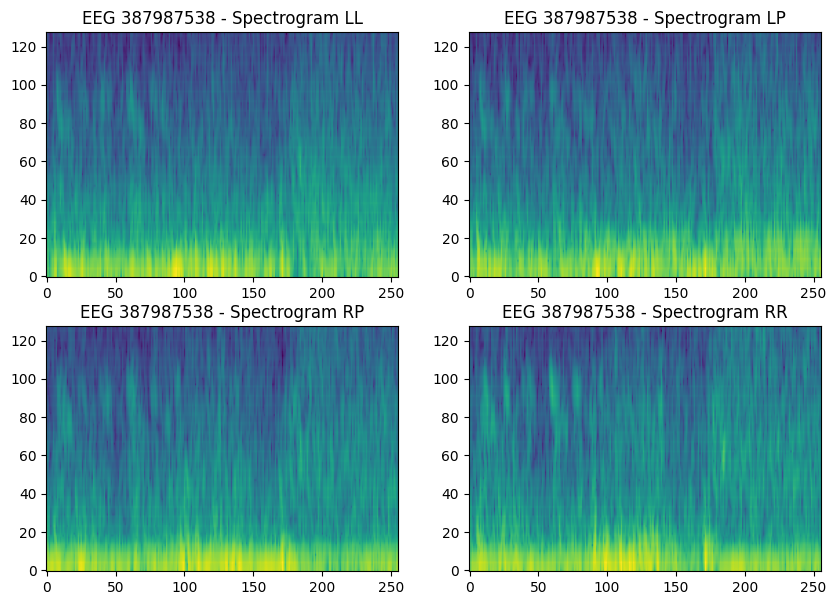

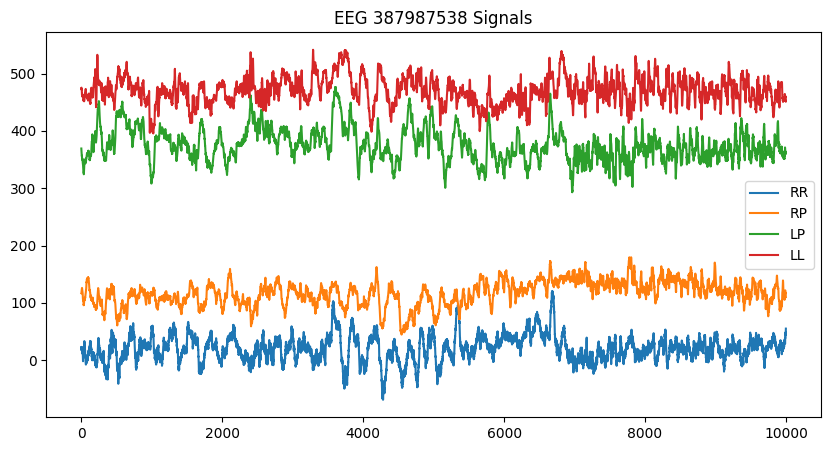


#########################

Creating and writing 17089 spectrograms to disk... 100 , 200 , 300 , 

KeyboardInterrupt: 

In [14]:
%%time
PATH = '/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/'
DISPLAY = 4
EEG_IDS = train.eeg_id.unique()
all_eegs = {}

for i,eeg_id in enumerate(EEG_IDS):
    if (i%100==0)&(i!=0): print(i,', ',end='')
        
    # CREATE SPECTROGRAM FROM EEG PARQUET
    img = spectrogram_from_eeg(f'{PATH}{eeg_id}.parquet', i<DISPLAY)
    
    # SAVE TO DISK
    if i==DISPLAY:
        print(f'Creating and writing {len(EEG_IDS)} spectrograms to disk... ',end='')
    np.save(f'{directory_path}{eeg_id}',img)
    all_eegs[eeg_id] = img
   
# SAVE EEG SPECTROGRAM DICTIONARY
np.save('eeg_specs',all_eegs)